# CA684 Machine Learning Exercise 3 - Logistic Regression and Extensions

In this exercise we'll implement logistic regression and apply it to a classification task.  We'll also extend the model in two ways: i) Regularized version of LR and ii) Locally weighted kernel LR. The latter will form a part of your assignment. 

## Logistic regression

In the first part of this exercise, we'll build a logistic regression model to predict whether a student gets admitted to a university.  Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression.  For each training example, you have the applicant's scores on two exams and the admissions decision.  To accomplish this, we're going to build a classification model that estimates the probability of admission based on the exam scores.

Let's start by examining the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
path = 'ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Let's create a scatter plot of the two scores and use color coding to visualize if the example is positive (admitted) or negative (not admitted).

/home/kevin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


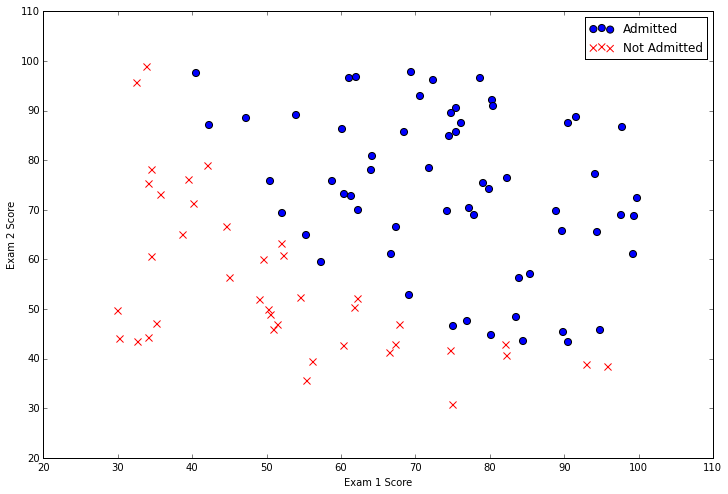

In [3]:
positive1 = data[data['Admitted'].isin([1])]
negative1 = data[data['Admitted'].isin([0])]

fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.scatter(positive1['Exam 1'], positive1['Exam 2'], s=50, c='b', marker='o', label='Admitted')
ax1.scatter(negative1['Exam 1'], negative1['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')
ax1.legend()
ax1.set_xlabel('Exam 1 Score')
ax1.set_ylabel('Exam 2 Score')

It looks like there is a clear decision boundary between the two classes.  Now we need to implement logistic regression so we can train a model to predict the outcome.  The equations implemented in the following code samples are detailed in "ex2.pdf" in the "exercises" folder.

First we need to create a sigmoid function.  The code for this is pretty simple.

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Let's do a quick sanity check to make sure the function is working.

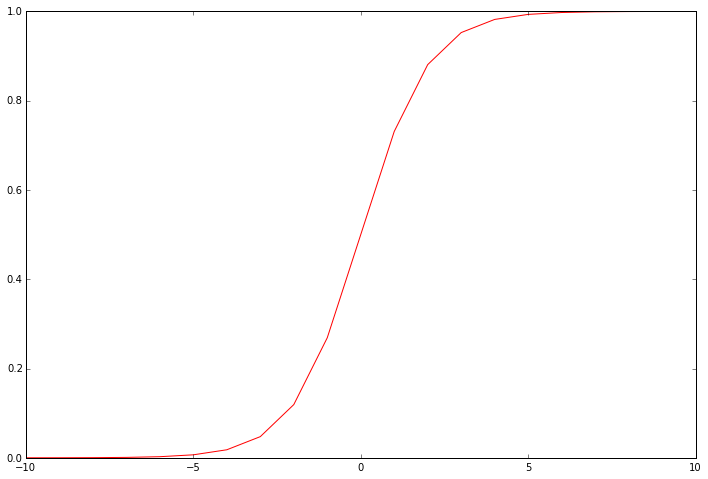

In [5]:
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums, sigmoid(nums), 'r')

Excellent!  Now we need to write the cost function to evaluate a solution.

In [6]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    return np.sum(first - second) / (len(X))

Now we need to do some setup, similar to what we did in for linear regression.

In [7]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(3)

Let's quickly check the shape of our arrays to make sure everything looks good.

In [8]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

Now let's compute the cost for our initial solution (0 values for theta).

In [9]:
cost(theta, X, y)

0.69314718055994529

Looks good.  Next we need a function to compute the gradient (parameter updates) given our training data, labels, and some parameters theta.

In [10]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
    
    return grad

Note that <b>we don't actually perform gradient descent in this function - we just compute a single gradient step </b>.  We can use SciPy's "optimize" namespace to do the gradient descent on the defined gradient function.

Let's look at a single call to the gradient method using our data and initial paramter values of 0.

In [11]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

Now we can use SciPy's truncated newton (TNC) implementation to find the optimal parameters.

In [12]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
result

(array([-25.16131868,   0.20623159,   0.20147149]), 36, 0)

Let's see what the our cost looks like with this solution.

In [13]:
cost(result[0], X, y)

0.20349770158947439

Next we need to write a function that will output predictions for a dataset X using our learned parameters theta.  We can then use this function to score the training accuracy of our classifier.

In [14]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [15]:
theta_min = np.matrix(result[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print 'accuracy = {0}%'.format(accuracy)

accuracy = 89%


Our logistic regression classifer correctly predicted if a student was admitted or not 89% of the time.  Not bad!  Keep in mind that this is training set accuracy though.  We didn't keep a hold-out set or use cross-validation to get a true approximation of the accuracy so this number is likely higher than its true perfomance.

## Regularized logistic regression

In the second part of this exercise, we'll improve our logistic regression algorithm from part one by adding a regularization term.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests.  From these two tests, you would like to determine whether the microchips should be accepted or rejected.  To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

Similar to part 1, let's start by visualizing the data.

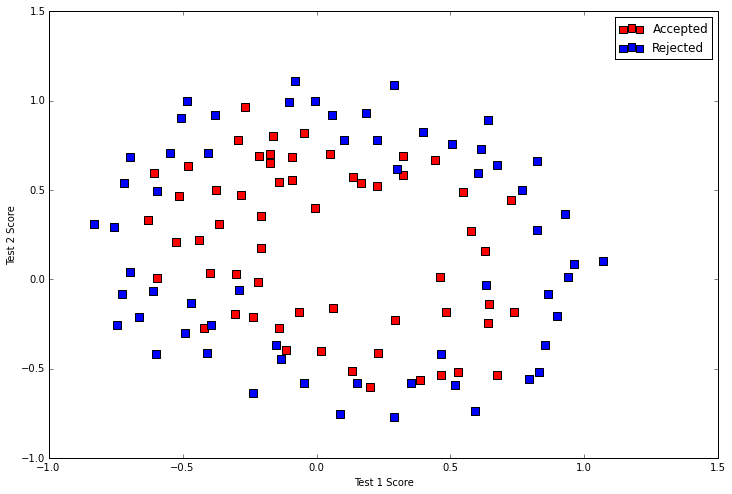

In [16]:
path = 'ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='r', marker='s', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='b', marker='s', label='Rejected')

ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

This data looks a bit more complicated than the previous example.  In particular, you'll notice that there is no linear decision boundary that will perform well on this data.  One way to deal with this using a linear technique like logistic regression is to <b>construct features that are derived from polynomials of the original features.  Let's start by creating a bunch of polynomial features</b>.

In [17]:
degree = 5
x1 = data2['Test 1']
x2 = data2['Test 2']

data2.insert(3, 'Ones', 1)
temp = data2.drop('Accepted',axis = 1)


In [18]:
for i in range(1, degree):
    for j in range(0, i):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)

data2.head()

,Accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


Now we need to modify the cost and gradient functions from part 1 to include the regularization term.  First the cost function:

In [19]:
def costReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

Notice the "reg" term in the equation.  Also note the addition of a "learning rate" parameter (or <b> regularization parameter</b>).  This is a hyperparameter that controls the effectiveness of the regularization term.  Now we need to add regularization to the gradient function:

In [20]:
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad

Initialize variables like we did in part 1.

In [21]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]
X2 = data2.iloc[:,1:cols]
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(11)

Let's initialize our learning rate to a sensible value.  We can play with this later if necessary (i.e. if the penalization is too strong or not strong enough).

In [22]:
learningRate = 1

Now let's try calling our new regularized functions with the default (0) values for theta to make sure the calculations are working.

In [23]:
costReg(theta2, X2, y2, learningRate)

0.6931471805599454

In [24]:
gradientReg(theta2, X2, y2, learningRate)

array([ 0.00847458,  0.01878809,  0.05034464,  0.01150133,  0.01835599,
        0.00732393,  0.00819244,  0.03934862,  0.00223924,  0.01286005,
        0.00309594])

Now we can use the same optimization function from part 1 to compute the optimal solution.

In [25]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))
result2

(array([  0.35873526,  -3.22365054,  18.96887361,  -4.25776959,
         18.23222204,  20.35972338,   8.94164472, -43.77198116,
        -17.92474656, -50.74170203,  -2.83326414]), 101, 1)

Finally, we can use the prediction function from part 1 to see how accurate our solution is on the training data.

In [26]:
costReg(result2[0], X2, y2,learningRate)

0.43443865704862972

In [27]:
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) % len(correct))
print 'accuracy = {0}%'.format(accuracy)

accuracy = 91%


<h2> Exercise 1: </h2>

Although we implemented these algorithms from scratch, you could use a high-level python library like scikit-learn to solve this problem. Find out how to implement regularized LogR (Logistic Regression) with the help of Scipy built-in functions.

# Exercise 1

## Logistic Regression using sklearn on the first dataset

In order to get familiar with logistic regression in sklearn we carried it out on our first dataset. 

In [28]:
from sklearn.linear_model import LogisticRegression

#we change the shape of y to a 1D-array
y_adapted = np.ravel(y)

#we create a LogisticRegression object and fit a model to the data
log_model = LogisticRegression()
log_model.fit(X,y_adapted)
print 'Accuracy  %.2f %%'% (log_model.score(X,y_adapted)*100)

Accuracy  91.00 %


As stated previously, the accuracy value is higher using the scikit-learn functions. 

In [29]:
print log_model.intercept_, log_model.coef_

[-2.85831439] [[-2.85831439  0.05214733  0.04531467]]


The previous allow us to write the following equation to fit a model to our data: 

$$Admission = \frac{1}{1+exp(2.85831439 - 0.05214733 * Exam1 - 0.04531467 * Exam2)} $$

## Regularized Logistic Regression using sklearn

Here, we used two methods in order to carry out the regularized logistic regression. First, we created a LogisticRegressionCV object which has a default penalty value of 'l2'.

In [30]:
from sklearn.linear_model import LogisticRegressionCV
log_model_reg = LogisticRegressionCV()
#we change the shape of y2 to a 1D-array
y2_adapted = np.ravel(y2)
log_model_reg.fit(X2,y2_adapted)
print 'Accuracy  %.2f %%'% (log_model_reg.score(X2,y2_adapted)*100)

Accuracy  77.12 %


In [31]:
print log_model_reg.intercept_, log_model_reg.coef_

[ 0.55157577] [[ -0.17688936  -2.97266418  18.14057681  -4.50290215  17.21479091
   19.2499604    8.16089561 -41.89079273 -16.22289491 -48.5802461
   -2.05359072]]


Moreover, we used the cross-validation method to get a training set for the prediction and a testing set for the valdiation, in order to confirm our previous results. And in effect, we obtained the same accuracy rate as previously. 

In [32]:
from sklearn.cross_validation import train_test_split 
from sklearn import metrics 

#testing, training data sets (75%/25%) split
X_train, X_test, Y_train, Y_test = train_test_split(X2,y2_adapted)
log_model_reg.fit(X2,y2_adapted)

#taking model to predict our X2 set
class_predict = log_model_reg.predict(X2)
print 'Accuracy percentage using cross-validation: %.2f %%' % (metrics.accuracy_score(y2_adapted, class_predict)*100)

Accuracy percentage using cross-validation: 77.12 %


Because we obtained a less accurate percentage than with the already implemented functions, we used the L1 Regularized Logistic Regression from the statsmodels library with the fit_regularized() function and then printed a summary of the stats, especially we can notice the parameters which were penalized. 

We needed to keep in mind that using regularization, we wanted to avoid overfitting. Hence, we penalised the parameters. With a large regularization parameter value, the algorithm would have resulted in underfitting. So we selected a value of $ \lambda = 1$. Thus, even if we fit a high order polynomial with a lot of parameters, the fact of applying regularization and keeping our parameters smalled allow us to have a simpler  hypothesis, which was less prone to overfitting.

In [33]:
from statsmodels.discrete.discrete_model import Logit

model = Logit(y2, X2)
res = model.fit_regularized(alpha=1, disp=False)
print res.summary()

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  118
Model:                          Logit   Df Residuals:                      113
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Feb 2016   Pseudo R-squ.:                  0.1237
Time:                        19:11:47   Log-Likelihood:                -71.658
converged:                       True   LL-Null:                       -81.774
                                        LLR p-value:                 0.0004493
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5553      0.334      1.665      0.096        -0.099     1.209
x1             0.0744      0.465      0.160      0.873        -0.836     0.985
x2            -2.3281      2.517     -0.925      0.3

We have the same value of intercept, using the LogisticRegression method. However, parameters x4, x5, x6, x8, x9 and x10 were penalized and as a consequence are now equal to 0. The regularization allowed to avoid overfitting. 

# Exercise 2

<h2> Exercise 2: </h2>

Implement a kernelized version of LogR.

With <b> Kernel Logistic Regression </b>, we are able to obtain non-linear decision boundaries. The objective function is modified with a local weight parameter, $w^{(i)}$, corresponding to the training set point $x^{(i)}$.

Modify the likelihood function (refer to your notes from the board-work of the third class) to:

$$L(\theta) = \prod_{i=1}^M w^{(i)} P(y^{(i)}|x^{(i)};\theta)$$

$$w^{(i)} = exp(\frac{||x^{(i)} - x||}{2\tau^2})$$

Redefine the new gradient function (similar to what we have done for incorporating the reguarization parameter). Your kernel weighted version of the gradient function should take in the bandwidth parameter as an argument. Optimize your new gradient function with the inbuilt opt.fmin_tnc function. (You should explain the kernelized likelihood and the gradient functions with detailed derivations.) Also, plot the decision boundary obtained with the kernelized LR. How is the decision boundary affected with the bandwidth parameter?

## Response 

The cost function is defined as follows: 
$$ J(\theta) = - \frac{1}{M}*\sum_{i=1}^M w^{(i)}*[log(h_{\theta}(x))*y + log(1 - h_{\theta}(x))*(1 - y)] $$
with $$w^{(i)} = exp(\frac{||x^{(i)} - x||}{2\tau^2})$$
and $$h_{\theta}(x) = \frac{1}{1+exp(-\theta^{T}*x)} $$

In the follwong steps we want to minimize the negative log likelihood in order to "descend" for minimization. 

In [34]:
#define a function for the weight 
from scipy.spatial.distance import pdist, squareform
def weight(X, bandwidth): 
    pairwise_dists = squareform(pdist(X, 'euclidean'))
    return np.exp(pairwise_dists ** 2 / (2* bandwidth ** 2))

We adapted the cost function and gradient descent to the Kernel Logistic Regression and then, we optimized the new gradient using the opt.fmin_tnc function. 

In [35]:
def costKer(theta, X, y, learningRate,bandwidth):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(np.multiply((first - second),weight(X,bandwidth)) / (len(X))) + reg

In [36]:
bandwidth = 0.2

In [37]:
costKer(theta2, X2, y2, learningRate,bandwidth)

5.1105672856047658e+41

In [38]:
def gradientKer(theta, X, y, learningRate, bandwidth):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    W = weight(X,bandwidth)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(np.multiply(W[:,0],term)) / len(X)
        else:
            grad[i] = (np.sum(np.multiply(W[:,i],term)) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad

In [39]:
gradientKer(theta2, X2, y2, learningRate, bandwidth)

array([  2.74233481e+28,   3.74216297e+30,   3.18618701e+32,
         4.02969758e+33,   3.85344564e+35,   6.09672368e+34,
         1.76850620e+33,   8.59189024e+32,   2.10677030e+28,
         5.04537524e+27,   9.88177679e+22])

In [40]:
result3 = opt.fmin_tnc(func=costKer, x0=theta2, fprime=gradientKer, args=(X2, y2, learningRate,bandwidth))
result3

(array([  3.97872471e-05,   1.28372554e-03,  -1.54424038e-01,
         -1.07502768e+00,  -9.22154151e-01,  -1.31807202e+00,
         -6.11924658e-01,  -4.15931191e-01,   1.17911982e-05,
         -2.65527353e-06,  -4.09170531e-12]), 63, 4)

In [41]:
costKer(result3[0], X2, y2, learningRate,bandwidth)

3.5642292231260094e+41

In [42]:
theta_min2 = np.matrix(result3[0])
predictions2 = predict(theta_min2, X2)
correct2 = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions2, y2)]
accuracy2 = (sum(map(int, correct2)) % len(correct2))
print 'accuracy = {0}%'.format(accuracy2)

accuracy = 66%


In order to show the decision boundary, we used 2 different colors:  
<ol>
<li>Red color for the accepted microships, except that the square-shaped are the one originated from ours test data and the x-shaped ones are the ones which were predicted to be accepted. </li>

<li>Blue color for the for the rejected microships, except that the square-shaped are the ones originated from our test data and the x-shaped ones are the ones which were predicted to be rejected. 
</li>

</ol>

Then, by superposition, we could tell how effective was the Kernel Logistic Regression method with respect to variations of the bandwidth value. 

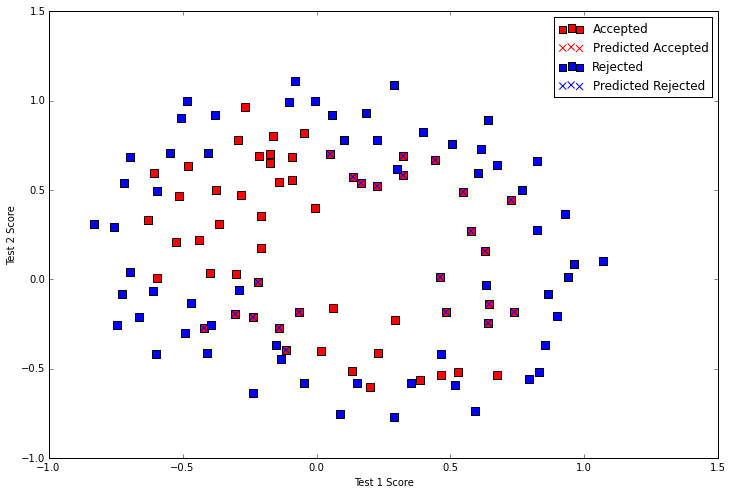

In [43]:
path = 'ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

data2_pred = data2
data2_pred["Predicted"] = pd.Series(correct2)
positive_pred = data2_pred[data2_pred['Predicted'].isin([1])]
negative_pred = data2_pred[data2_pred['Predicted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='r', marker='s', label='Accepted')
ax.scatter(positive_pred['Test 1'], positive_pred['Test 2'], s=50, c='r', marker='x', label='Predicted Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='b', marker='s', label='Rejected')
ax.scatter(negative_pred['Test 1'], negative_pred['Test 2'], s=50, c='b', marker='x', label='Predicted Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

The following lines gave us insights about how many predicted points matched the actual data points from the testing set. 

In [44]:
#data2_pred[data2_pred["Predicted"]==1]["Predicted"]
matched_accepted = [True if ((data2["Accepted"][i]==1)and(data2_pred["Predicted"][i]==1)) else False for i in range(0,118)]
matched_rejected = [True if ((data2["Accepted"][i]==0)and(data2_pred["Predicted"][i]==0)) else False for i in range(0,118)]

In [45]:
print '%d matches for accepted and %d matches for rejected => %d points wrongly matched' % (sum(matched_accepted),sum(matched_rejected),118-sum(matched_accepted)-sum(matched_rejected))

35 matches for accepted and 29 matches for rejected => 54 points wrongly matched


By varying the value of the bandwidth $ \sigma^2 $, we have the follwing results: 

<ul>
    <li> $\sigma^2 $ = 0.2 => 66% accuracy. As a result just 54 predicted points were wrongly matched.  </li>
         <li> $\sigma^2 $ = 0.5 => 79% accuracy. As a result just 51 predicted points were wrongly matched. </li>
            <li> $\sigma^2 $ = 1 =>  91% accuracy. As a result just 47 predicted points were wrongly matched.  </li>
</ul>

Hence, we notice that a small value of sigma implies more unmatched predicted points and we concluded the following: 
<ol>
<li> A small value of $\sigma^2$ means a lower bias and a higher variance. And a high variance can cause overfitting. </li>
<li> A large value of $\sigma^2$ means a higher bias and a lower variance. And a high bias can cause underfitting. </li>
</ol>